# Assignment 01 Human Activity Recognition
## Running style detection - Forefoot vs Heel strike running
#### Nikhil Kumar - Nkmu576

The following is an investigation into using computational signal processing techniques to develop a machine learning algorithm which can recognise the difference between running styles. 

The two running styles recorded are forefoot strike running and heel strike running. It is generally accepted that heel strike running is inferior to forefoot strike running for a number of reasons. One major reason is due to the increased amount of stress placed on the joints, and having more impact transmitted through the shin to the lower back. Forefoot running is a more optimal and safer way to run, with the muscles in a more optimal position to absorb the impact of running and a bent knee means less shock impact is transfered to the knees and shins. 

Thus for a hypothetical health application use would be to have an mobile app or tracker which can monitor the style of running, such that someone may want to begin to switch to a forefoot style of running, and monitor their progress.


To record these accleration signals, an iPhone was strapped to my shin, and the various running styles was recorded over a single running session 


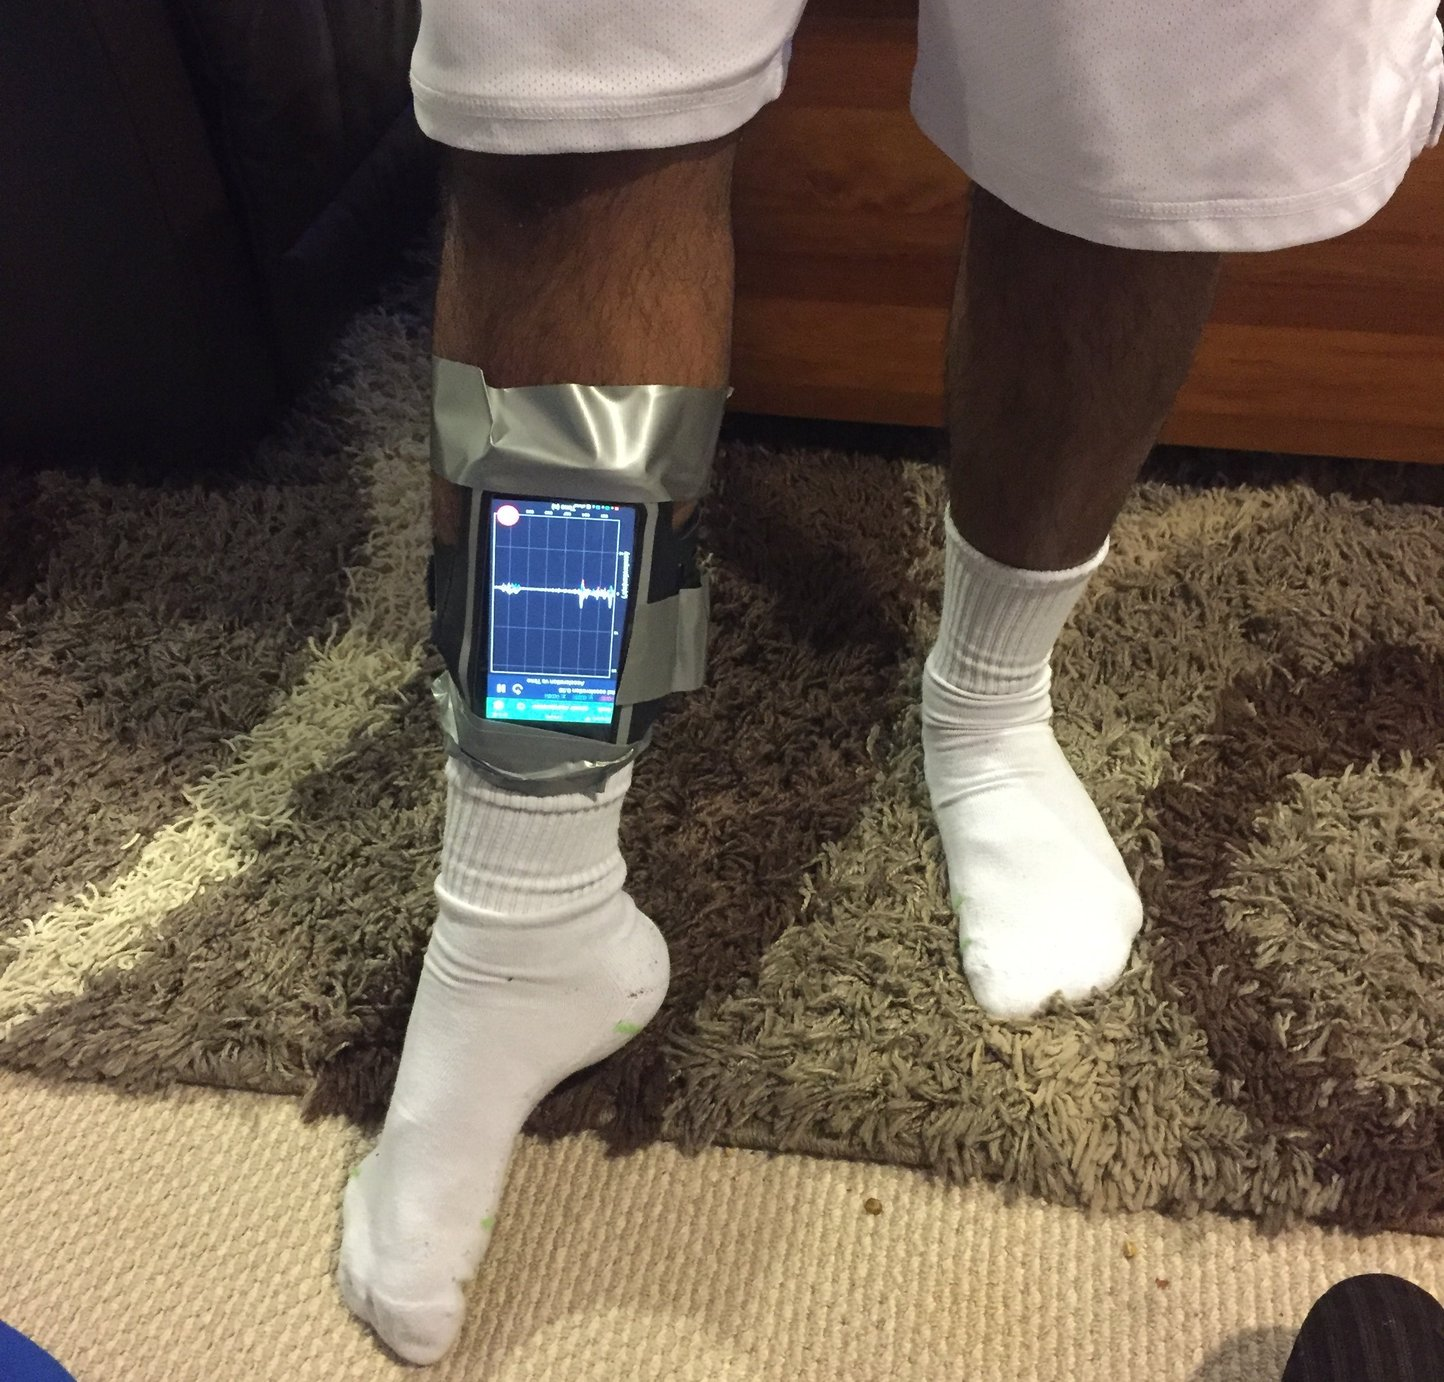

In [648]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tsfresh
tsfresh.__version__

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Importing the data

In [649]:
trainforefoot = pd.read_csv('forefrontconcrete.csv', index_col = 'time',skiprows = 0, infer_datetime_format = True )
trainheel = pd.read_csv('Heelrunconcrete.csv', index_col = 'time', skiprows = 0, infer_datetime_format = True)

In [650]:
trainforefoot.head()

,ax,ay,az,atotal
time,,,,
2021-09-03 18:56:06.0150,0.20,-0.16,-0.03,0.25
2021-09-03 18:56:06.0170,-0.33,-0.15,-0.18,0.40
2021-09-03 18:56:06.0180,-0.38,-0.18,-0.44,0.60
2021-09-03 18:56:06.0260,0.35,0.02,-0.78,0.85
2021-09-03 18:56:06.0310,0.26,0.02,-0.29,0.39


In [651]:
trainheel.head()

,ax,ay,az,atotal
time,,,,
2021-09-03 18:45:41.1360,-0.72,-0.56,-0.52,1.04
2021-09-03 18:45:41.1460,-0.83,-0.64,-0.39,1.11
2021-09-03 18:45:41.1560,-0.24,0.19,0.00,0.30
2021-09-03 18:45:41.1660,-0.50,0.18,0.03,0.53
2021-09-03 18:45:41.1760,-0.76,0.07,-0.08,0.76


##### Producing the time delta column

In [652]:
trainforefoot.index = pd.to_datetime(trainforefoot.index)
delta_t_forefoot = trainforefoot.index - trainforefoot.index[0]

In [653]:
trainheel.index = pd.to_datetime(trainheel.index)
delta_t_heel = trainheel.index - trainheel.index[0]

In [654]:
trainforefoot['delta_t'] = delta_t_forefoot
trainheel['delta_t'] = delta_t_heel

In [655]:
def plot_XYZ(ts, title):
    dt = 0.01 # milliseconds
    plt.plot(ts.delta_t, ts.ax, label='x')[:4]
    plt.plot(ts.delta_t, ts.ay, label='y')[:4]
    plt.plot(ts.delta_t, ts.az, label='z')[:4]
    plt.plot(ts.delta_t, ts.atotal, label='total')[:4]
    plt.xlabel('time')
    plt.ylabel('acceleration')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

##### Plotting data

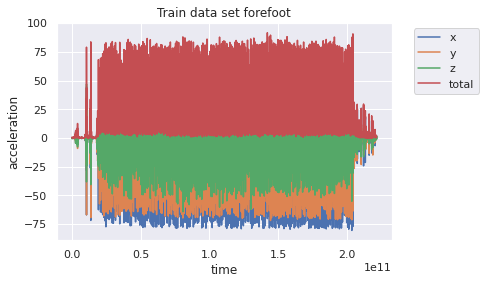

In [656]:
plot_XYZ(trainforefoot, 'Train data set forefoot')

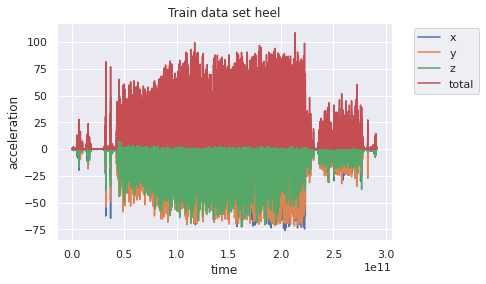

In [657]:
plot_XYZ(trainheel, 'Train data set heel')

The obvious differences between the two running styles is the consistency of the signals. The forefoot strike running plot shows the acceleration values to be consistent throughout the run, and further inspection shows the forefoot running to be very periodic. The feature which may show to be a good feature for systematic feature engineering would be the maximum acceleration.

Transition times were made easier to identify by first running the acceleration recording application and then starting each activity by first jumping up twice in a row. This can be seen in the two plots as two peaks before the rest of the data.

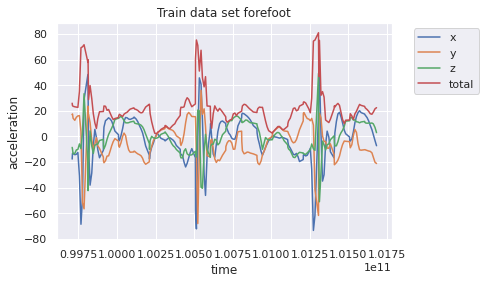

In [658]:
plot_XYZ(trainforefoot[10000:10200],'Train data set forefoot')

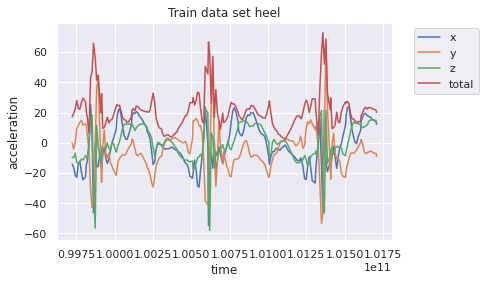

In [659]:
plot_XYZ(trainheel[10000:10200], 'Train data set heel')

##### Cutting out transitions

In [660]:
Prunedtrainforefoot = trainforefoot.truncate(before = '2021-09-03 18:56:22.956000', after = '2021-09-03 18:59:25.445000')
Prunedtrainheel = trainheel.truncate(before = '2021-09-03 18:46:23.019000', after = '2021-09-03 18:49:25.013000')

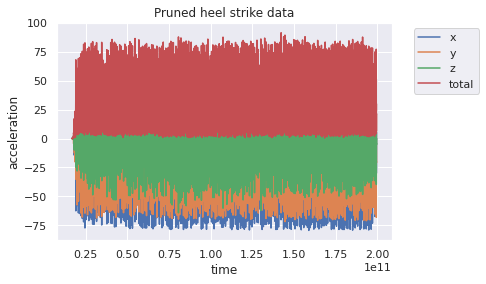

In [661]:
plot_XYZ(Prunedtrainforefoot, 'Pruned heel strike data')

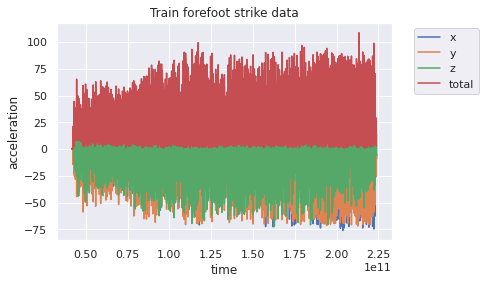

In [662]:
plot_XYZ(Prunedtrainheel, 'Train forefoot strike data')

In [663]:
print("Length of pruned activities (timestamp):")
print((Prunedtrainforefoot.iloc[-1].delta_t - Prunedtrainforefoot.iloc[0].delta_t) )
print((Prunedtrainheel.iloc[-1].delta_t - Prunedtrainforefoot.iloc[0].delta_t))
print("Length of pruned activities (seconds):")
print((Prunedtrainforefoot.iloc[-1].delta_t - Prunedtrainforefoot.iloc[0].delta_t).total_seconds() )
print((Prunedtrainheel.iloc[-1].delta_t - Prunedtrainforefoot.iloc[0].delta_t).total_seconds())

Length of pruned activities (timestamp):
0 days 00:03:02.489000
0 days 00:03:26.936000
Length of pruned activities (seconds):
182.489
206.936


##### Attaching Windowing Index

In [664]:
idheel =  np.asarray(np.floor(Prunedtrainheel.reset_index().index / 100).values, np.int64)
Prunedtrainheel['window_idx'] = ['H{:03}'.format(i) for i in idheel]
Prunedtrainheel

,ax,ay,az,atotal,delta_t,window_idx
time,,,,,,
2021-09-03 18:46:23.019,0.29,-0.07,-0.25,0.38,0 days 00:00:41.883000,H000
2021-09-03 18:46:23.029,0.31,-0.04,-0.17,0.35,0 days 00:00:41.893000,H000
2021-09-03 18:46:23.039,0.18,-0.08,0.00,0.19,0 days 00:00:41.903000,H000
2021-09-03 18:46:23.049,0.07,-0.01,0.03,0.07,0 days 00:00:41.913000,H000
2021-09-03 18:46:23.059,0.01,0.09,-0.05,0.10,0 days 00:00:41.923000,H000
...,...,...,...,...,...,...
2021-09-03 18:49:24.974,-5.40,-2.72,-2.33,6.47,0 days 00:03:43.838000,H182
2021-09-03 18:49:24.984,-6.15,-6.01,-4.29,9.60,0 days 00:03:43.848000,H182
2021-09-03 18:49:25.001,-5.84,-8.18,-5.31,11.36,0 days 00:03:43.865000,H182


In [665]:
idForefoot =  np.asarray(np.floor(Prunedtrainforefoot.reset_index().index / 100).values, np.int64)
Prunedtrainforefoot['window_idx'] = ['FF{:03}'.format(i) for i in idForefoot]
Prunedtrainforefoot

,ax,ay,az,atotal,delta_t,window_idx
time,,,,,,
2021-09-03 18:56:22.956,0.18,-0.13,0.36,0.42,0 days 00:00:16.941000,FF000
2021-09-03 18:56:22.958,0.18,-0.14,0.13,0.26,0 days 00:00:16.943000,FF000
2021-09-03 18:56:22.964,0.20,-0.07,0.01,0.21,0 days 00:00:16.949000,FF000
2021-09-03 18:56:22.973,0.26,0.03,-0.02,0.26,0 days 00:00:16.958000,FF000
2021-09-03 18:56:22.984,0.22,0.00,-0.01,0.22,0 days 00:00:16.969000,FF000
...,...,...,...,...,...,...
2021-09-03 18:59:25.392,-17.07,-8.41,0.42,19.03,0 days 00:03:19.377000,FF182
2021-09-03 18:59:25.402,-13.31,-14.36,-0.42,19.58,0 days 00:03:19.387000,FF182
2021-09-03 18:59:25.412,-5.24,-19.51,-3.33,20.47,0 days 00:03:19.397000,FF182


In [666]:
trainrunningstyle = pd.concat([ Prunedtrainheel,Prunedtrainforefoot], axis=0)

In [667]:
print("Unique values of windowing index:")
print(trainrunningstyle['window_idx'].nunique())

Unique values of windowing index:
367


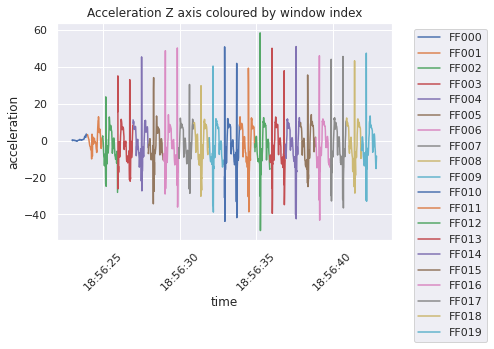

In [668]:
def plot_windows(df, style='-'):
    for id in np.unique(df['window_idx'])[:20]:
        plt.plot(df.az[df.window_idx == id], style, label=id)
        plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('time')
    plt.ylabel('acceleration')
    plt.title('Acceleration Z axis coloured by window index')
    
plot_windows(trainrunningstyle)

In [669]:
from tsfresh.feature_extraction.settings import EfficientFCParameters
efficient = EfficientFCParameters()

In [670]:
from tsfresh.feature_extraction import extract_features

In [671]:
runFeatures = extract_features(trainrunningstyle, column_id='window_idx', column_sort='delta_t', default_fc_parameters=efficient)

Feature Extraction: 100%|███████████████████████| 30/30 [00:18<00:00,  1.64it/s]


In [672]:
runFeatures.head()

,ax__variance_larger_than_standard_deviation,ax__has_duplicate_max,ax__has_duplicate_min,ax__has_duplicate,ax__sum_values,ax__abs_energy,ax__mean_abs_change,ax__mean_change,ax__mean_second_derivative_central,ax__median,...,atotal__fourier_entropy__bins_2,atotal__fourier_entropy__bins_3,atotal__fourier_entropy__bins_5,atotal__fourier_entropy__bins_10,atotal__fourier_entropy__bins_100,atotal__permutation_entropy__dimension_3__tau_1,atotal__permutation_entropy__dimension_4__tau_1,atotal__permutation_entropy__dimension_5__tau_1,atotal__permutation_entropy__dimension_6__tau_1,atotal__permutation_entropy__dimension_7__tau_1
FF000,0.0,0.0,0.0,1.0,37.23,50.3863,0.116667,0.027778,0.001582,0.190,...,0.165443,0.192626,0.288342,0.383650,0.602410,1.497126,2.341725,3.091699,3.650973,3.930828
FF001,1.0,0.0,0.0,1.0,112.40,4914.1150,2.019899,-0.029192,-0.004082,0.120,...,0.223718,0.261160,0.356468,0.478541,1.075914,1.394151,2.155923,2.764079,3.228286,3.492894
FF002,1.0,0.0,0.0,1.0,-392.71,22197.8045,4.694949,-0.484646,0.049643,-2.750,...,0.165443,0.261160,0.356468,0.651889,2.012317,1.525438,2.413556,3.115331,3.730360,4.100860
FF003,1.0,0.0,0.0,1.0,-51.27,21045.7153,6.076566,0.024242,-0.123827,-0.845,...,0.165443,0.165443,0.464277,0.624706,1.584415,1.498687,2.333247,3.059027,3.626821,4.028785
FF004,1.0,0.0,0.0,0.0,52.24,18931.8658,4.842828,-0.165051,-0.016327,0.485,...,0.223718,0.319026,0.356468,0.806540,2.330643,1.522696,2.464785,3.308964,3.893780,4.207710


In [673]:
runFeatures.shape

(367, 3112)

In [674]:
print("Number of features extracted:")
print(runFeatures.shape[1])

Number of features extracted:
3112


In [675]:
runFeatures.index.unique()

Index(['FF000', 'FF001', 'FF002', 'FF003', 'FF004', 'FF005', 'FF006', 'FF007',
       'FF008', 'FF009',
       ...
       'H173', 'H174', 'H175', 'H176', 'H177', 'H178', 'H179', 'H180', 'H181',
       'H182'],
      dtype='object', length=367)

In [676]:
runFeatures.nunique()

ax__variance_larger_than_standard_deviation          2
ax__has_duplicate_max                                2
ax__has_duplicate_min                                1
ax__has_duplicate                                    2
ax__sum_values                                     366
                                                  ... 
atotal__permutation_entropy__dimension_3__tau_1    329
atotal__permutation_entropy__dimension_4__tau_1    366
atotal__permutation_entropy__dimension_5__tau_1    366
atotal__permutation_entropy__dimension_6__tau_1    358
atotal__permutation_entropy__dimension_7__tau_1    286
Length: 3112, dtype: int64

##### Logisitic Regression for comparison to feature selection

In [677]:
from sklearn.linear_model import LogisticRegression

In [678]:
clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

In [679]:
labels = trainrunningstyle.window_idx

In [680]:
labelbool = pd.DataFrame(labels.unique(), columns = ['labels'])

In [681]:
babel = labelbool.labels.str.match('FF')

In [682]:
clf.fit(runFeatures.dropna(axis = 1),babel)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [683]:
np.abs(clf.coef_)[0,:].shape

(848,)

In [684]:
importance  = pd.Series(np.abs(clf.coef_)[0,:], index = runFeatures.dropna(axis = 1).columns)

In [685]:
list(importance[importance>0].index)

['ax__sum_values',
 'ax__abs_energy',
 'ax__length',
 'ax__variation_coefficient',
 'ax__absolute_sum_of_changes',
 'ax__count_below_mean',
 'ax__time_reversal_asymmetry_statistic__lag_1',
 'ax__time_reversal_asymmetry_statistic__lag_2',
 'ax__time_reversal_asymmetry_statistic__lag_3',
 'ax__c3__lag_1',
 'ax__c3__lag_2',
 'ax__c3__lag_3',
 'ax__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0',
 'ax__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
 'ax__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0',
 'ax__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0',
 'ax__fft_coefficient__attr_"real"__coeff_0',
 'ax__fft_coefficient__attr_"angle"__coeff_0',
 'ax__fft_aggregated__aggtype_"variance"',
 'ay__sum_values',
 'ay__abs_energy',
 'ay__length',
 'ay__count_above_mean',
 'ay__time_reversal_asymmetry_statistic__lag_1',
 'ay__time_reversal_asymmetry_statistic__lag_2',
 'ay__time_reversal_asymmetry_statistic__lag_3',
 'ay__c3__lag_1',
 'ay__c3__lag_

###### Dropping NaN values

In [686]:
cleanfeat = runFeatures.dropna(axis = 1)

In [687]:
cleanfeat.head()

,ax__variance_larger_than_standard_deviation,ax__has_duplicate_max,ax__has_duplicate_min,ax__has_duplicate,ax__sum_values,ax__abs_energy,ax__median,ax__mean,ax__length,ax__standard_deviation,...,atotal__ratio_beyond_r_sigma__r_7,atotal__ratio_beyond_r_sigma__r_10,"atotal__linear_trend_timewise__attr_""rvalue""",atotal__count_above__t_0,atotal__count_below__t_0,atotal__lempel_ziv_complexity__bins_2,atotal__lempel_ziv_complexity__bins_3,atotal__lempel_ziv_complexity__bins_5,atotal__lempel_ziv_complexity__bins_10,atotal__lempel_ziv_complexity__bins_100
FF000,0.0,0.0,0.0,1.0,37.23,50.3863,0.190,0.3723,100.0,0.604364,...,0.0,0.0,0.802283,1.0,0.0,0.14,0.18,0.23,0.33,0.66
FF001,1.0,0.0,0.0,1.0,112.40,4914.1150,0.120,1.1240,100.0,6.919377,...,0.0,0.0,0.488324,1.0,0.0,0.14,0.21,0.31,0.44,0.76
FF002,1.0,0.0,0.0,1.0,-392.71,22197.8045,-2.750,-3.9271,100.0,14.372054,...,0.0,0.0,0.006821,1.0,0.0,0.14,0.17,0.25,0.37,0.67
FF003,1.0,0.0,0.0,1.0,-51.27,21045.7153,-0.845,-0.5127,100.0,14.498079,...,0.0,0.0,0.034430,1.0,0.0,0.14,0.18,0.28,0.38,0.69
FF004,1.0,0.0,0.0,0.0,52.24,18931.8658,0.485,0.5224,100.0,13.749391,...,0.0,0.0,0.144728,1.0,0.0,0.14,0.17,0.23,0.36,0.64


In [688]:
target = trainrunningstyle.window_idx.unique()

In [689]:
w = pd.DataFrame(target)

In [690]:
p = pd.Series(babel)
w['label'] = p
w = w.set_index(0)

##### Feature Selection

In [691]:
from tsfresh.transformers import FeatureSelector
select = FeatureSelector()

In [692]:
select.fit(cleanfeat, w['label'])

FeatureSelector()

In [693]:
select.relevant_features

['ax__time_reversal_asymmetry_statistic__lag_3',
 'ay__maximum',
 'ax__minimum',
 'ax__c3__lag_3',
 'ax__fft_aggregated__aggtype_"variance"',
 'ax__ratio_beyond_r_sigma__r_1',
 'ay__c3__lag_1',
 'ay__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4',
 'ax__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0',
 'ay__lempel_ziv_complexity__bins_3',
 'ax__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
 'ax__number_peaks__n_1',
 'ay__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4',
 'ay__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
 'ax__standard_deviation',
 'ax__variance',
 'ax__abs_energy',
 'ax__ratio_beyond_r_sigma__r_3',
 'ax__c3__lag_2',
 'ax__ratio_beyond_r_sigma__r_2.5',
 'ay__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6',
 'ax__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0',
 'ax__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0',
 'ax__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql

In [694]:
Xselected = select.transform(cleanfeat)

In [695]:
selectlabel = ['ax__time_reversal_asymmetry_statistic__lag_3',
               'ay__maximum',
               'ax__minimum',
               'ax__c3__lag_3',
               'ax__fft_aggregated__aggtype_"variance"']

###### The 5 features with the smallest p-values are:

ax__time_reversal_asymmetry_statistic__lag_3,  ay__maximum,  ax__minimum,  ax__c3__lag_3, ax__fft_aggregated__aggtype_"variance, 

##### Pair Plot for top 5 relevant features

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000.]), [])

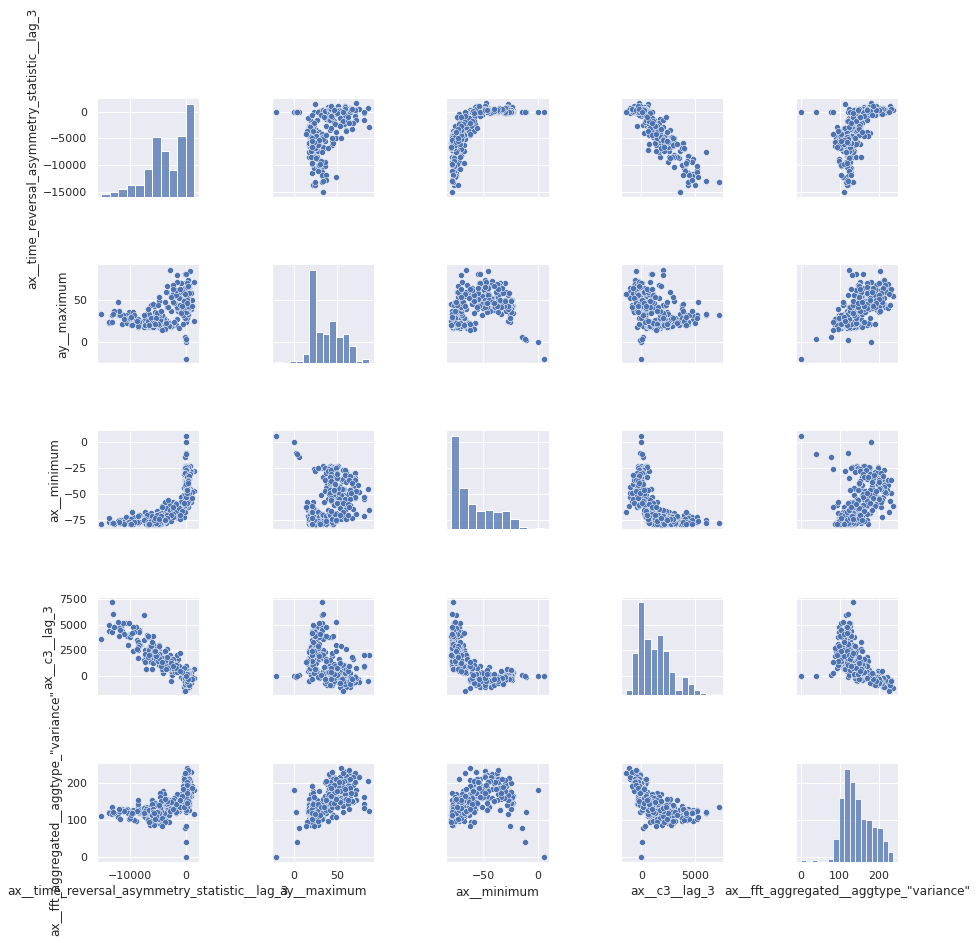

In [696]:
import seaborn as sns
sns.pairplot(Xselected[selectlabel])
plt.yticks(rotation=45)

##### Comparing features to rejection line of 0.01

In [697]:
K = len(select.p_values[0:50])
threshold = [(m+1)/(K * np.sum(1/(1+np.arange(K)))) * 0.01 for m in np.arange(K)]

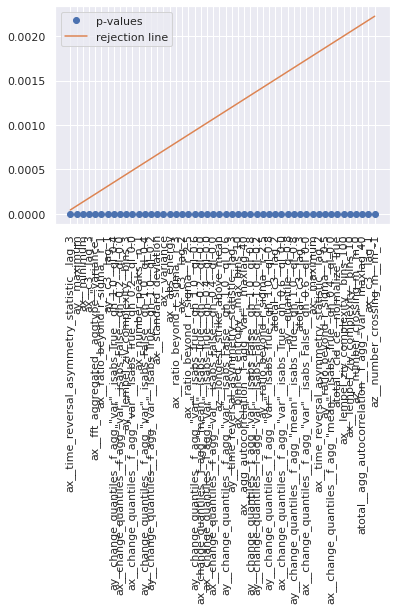

In [698]:
plt.plot(pd.Series(select.p_values[0:50], index=select.features[0:50]),'o', label='p-values')
plt.plot(threshold, label='rejection line') 
_= plt.xticks(rotation=90)
plt.legend()

##### Random Forest Classifier 

In [699]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [700]:
from sklearn.ensemble import RandomForestClassifier

In [701]:
rnd_clf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=16, n_jobs=-1)

In [702]:
rnd_clf.fit(Xselected, w['label'])

RandomForestClassifier(max_leaf_nodes=16, n_estimators=200, n_jobs=-1)

In [703]:
def plot_decision_function(clf, X, x1, x2, y):
    x1grid = np.linspace(X[x1].min()-0.1, X[x1].max()+0.1, 100)
    x2grid = np.linspace(X[x2].min()-0.1, X[x2].max()+0.1, 100)
    clf.fit(X[[x1,x2]], y)
    xx, yy = np.meshgrid(x1grid, x2grid)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    zz = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.RdBu, alpha=.8)
    plt.plot(X[x1][y], X[x2][y], 'ko', label=True)
    plt.plot(X[x1][~y], X[x2][~y], 'gx', label=False)
    plt.xlabel(x1)
    plt.ylabel(x2)
    plt.colorbar()
    plt.legend()
    plt.title('Random Forrest for ' + x1 + ' and ' + x2)

###### Decision plots against two features

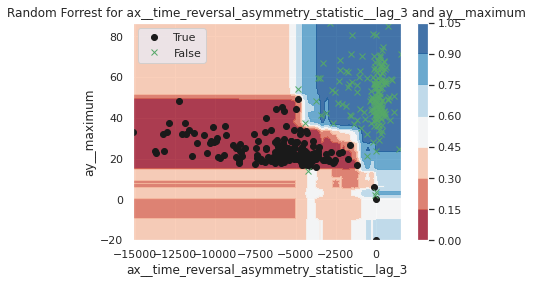

In [704]:
plot_decision_function(rnd_clf,cleanfeat,'ax__time_reversal_asymmetry_statistic__lag_3', 'ay__maximum', w['label'].astype("bool"))

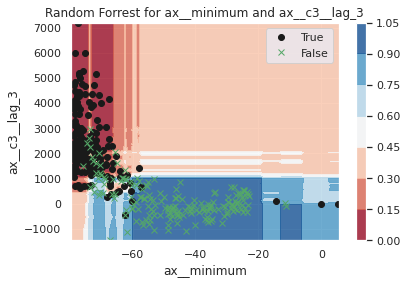

In [705]:
plot_decision_function(rnd_clf,cleanfeat,'ax__minimum',
 'ax__c3__lag_3', w['label'].astype("bool"))

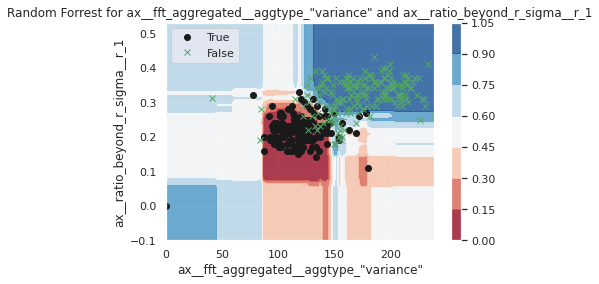

In [706]:
plot_decision_function(rnd_clf,cleanfeat,'ax__fft_aggregated__aggtype_"variance"',
 'ax__ratio_beyond_r_sigma__r_1', w['label'].astype("bool"))

##### Repeated KFolds Cross validation

In [707]:
from numpy import mean

In [708]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
	# evaluate model
	score = cross_val_score(rnd_clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return score

In [709]:
results = list()
# evaluate using a given number of repeats
scores = evaluate_model(Xselected, w['label'].astype("bool"))
results.append(scores)

In [710]:
print("Mean score:")
print(mean(results))

Mean score:
0.983663663663664


###### Grid Search for obtaining optimal classifier parameters and score

In [711]:
param_grid = {"max_depth": [3, None],
             "min_samples_split": [5, 20],
             "random_state" : [1,3],
             "n_estimators": [1,400],
             "max_leaf_nodes": [10,32],
             "min_samples_leaf": [1,240],
             "n_jobs":[1,10],
             "max_samples":[1,20] }

search = GridSearchCV(rnd_clf, param_grid, scoring='accuracy').fit(cleanfeat, w['label'])
search.best_params_

{'max_depth': 3,
 'max_leaf_nodes': 10,
 'max_samples': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400,
 'n_jobs': 1,
 'random_state': 1}

In [712]:
print("Score from Grid Search Cross Validation:")
search.best_score_

Score from Grid Search Cross Validation:


0.9534987041836356

The cross validation score for the classifier is incredibly high, and seems to show a high accuracy for identifying the two different running styles. 

The cost for any misclassifications, can vary, depending on the implementation of the health application. However, the risk caused by a misclassification is fairly limited.

If the application was running in real time, with some form of reminder whilst the runner is running the cost for misclassification can be fustration or distraction, espescially if measures which remind the runner to change their form may interfere with their concentration, and increase the likelihood of an injury. In this scenario, the applications decision model may be biased towards false negatives, such that the possibility of false positives may increase distraction to the user. However, the high accuracy of the classifier may make this a non issue.

A health tracking application, where the user can check their form after the running period would mean that the decision model would be left as is. Because of the high accuracy of the classifier, and the low risk associated with a misclassification, this in turn would not influence any changes. 